#### Student    : Nasrin Sultana Nipa
#### Student ID : 50618423
#### Assignment : 07
#### Course     : CS-6443-001

# Learning a Decision Tree

In this assignment, we will use the "Wine" dataset for the analysis.


In [28]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

We will load up the Wine dataset using Scikit-Learn. It will be split into an 80%/20% train/test split, stratified by class to maintain the same proportion of all three classes in each partition. 

In [29]:
X_all, y_all = load_wine(return_X_y=True, as_frame=False)
# Let's do a simple 80/20 Train/Test split, stratified to retain proportions for each class:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.20, random_state=2024, shuffle=True, stratify=y_all
)

Now, let's define the Gini impurity metric.  Since we only care about the _mixture_ of labels in our partition, the only argument needed here is `y` (not `X`).

In [30]:
def gini(y):
    """
    Computes and returns the GINI index of the labels in `y`
    """
    y = np.asarray(y)
    classes = np.unique(y)
    p = 0.0
    n_items = len(y)
    if n_items == 0:
        return 0
    for label in classes:
        p += (sum(y == label) / n_items) ** 2
    return 1.0 - p

### Learning a split threshold

Below, we will define the `learn_threshold()` function that will find the best _binary_ partition of a single random variable $x$ such that the misclassification error of the first class represented in $y$ versus all others is minimized.

The partition is based on the simple relation $x < t$ where $t$ is the threshold value that we are trying to learn.  We will try to pick thresholds that are "between" the neighboring values of $x$ where the class $y$ changes.  (No useful threshold will be found in areas in the range of $x$ where not class transitions are occurring.)

In [31]:
EPSILON = 1e-10


def learn_threshold(x, y):
    sort_idx = np.argsort(x)
    x_sorted, y_sorted = x[sort_idx], y[sort_idx]
    best_misc_err = 1.0
    best_thresh = x_sorted[0]
    for idx in range(len(x_sorted)):
        if idx < len(x_sorted) - 1 and y_sorted[idx] == y_sorted[idx + 1]:
            continue  # Skip runs where the labels are the same; focus on transitions
        left_class = y_sorted[0] if idx > 0 else None
        y_right = y[idx:]
        misc_err = sum(y_right == left_class) / len(y_sorted)
        if misc_err < best_misc_err:
            best_misc_err = misc_err
            best_thresh = (x[idx] + x[idx - 1]) / 2.0 if idx > 0 else x[idx] - EPSILON
    return best_thresh

### Tree induction

Now, we will define the `tree_induction` function.  This is the _training_ routine for learning a decision tree.

There are a lot of ways to represent a decision tree in practice.  We will choose to use a nested Python dictionary structure here, because it requires very little code to create it, and because Python dictionaries are fairly well optimized.

Each "Node" is a dictionary entry that knows the following things (some of which depend on whether or not the node is a leaf or a decision node):

* `is_leaf` : True if the node is a leaf, False otherwise.
* `split_idx` : The index (variable column) this decision node will split on (or None if the node is a leaf).
* `threshold` : The splitting threshold value (or None if the node is a leaf).
* `label` : The most numerous label for values reaching this node.
* `proba` : The probability that `label` is correct, given training values reaching this node.
* `impurity` : The impurity metric for all values reaching this node.
* `N` : The number of training values that reached this node.
* `left` : The child node where samples for which $X_{split\_idx} < \textrm{threshold}$.  Think of this as the "True" branch since our test is `<`.
* `right` : The child node where samples for which $X_{split\_idx} \geq \textrm{threshold}$.  Think of this as the "False" branch, since our test is `<`.

The nodes do not strictly require all of this information---`N` and `impurity` are provided in case you want to examine the tree to make sure the training is working correctly.

**Split Impurity**

We will designate the impurity of a proposed _split_ as the weighted sum of the impurities of the left partition at that split and the right partition.  We weight them with the number of samples that move into each partition.  The formula is:
$$
\operatorname{SplitImpurity} = \frac{N_{left}}{N} \operatorname{Impurity}_{left} + \frac{N_{right}}{N} \operatorname{Impurity}_{right}
$$

From this number, we can see the change in impurity that would be caused by doing the split.  We want the split to reduce the total impurity (if it does not, do not split).

$$
\Delta \operatorname{Impurity} = \operatorname{Impurity_{current}} - \operatorname{SplitImpurity}
$$
and we want
$$
\Delta \operatorname{Impurity} > 0
$$

In [32]:
def tree_induction(X, y, impurity_metric=gini):
    X, y = np.asarray(X), np.asarray(y)
    N, d = X.shape[0], X.shape[1]
    if N == 0 or d == 0:
        return None
    current_impurity = impurity_metric(y)
    current_label, vote_count = stats.mode(y)
    current_node = {
        "is_leaf": True,  # May change later
        "split_idx": None,  # Only set on decision nodes
        "threshold": None,  # Only set on decision nodes
        "label": current_label,
        "proba": vote_count / N,
        "impurity": current_impurity,
        "N": N,
        "left": None,  # Will be set later if needed.
        "right": None,  # Will be set later if needed.
    }
    # In case we already have only one class in this node, we can stop,
    # since this will be a leaf node.
    if current_impurity == 0:
        return current_node
    # Otherwise, find the best split by impurity metric
    best_split_imp = 1e20  # Acts as "infinity" for initial setting
    best_split_idx = 0
    best_split_threshold = 0
    for var_idx in range(d):
        threshold = learn_threshold(X[:, var_idx], y) # - call learn_threshold with only the var_idx column of X
        left_rows = X[:, var_idx] < threshold
        right_rows = np.logical_not(left_rows)
        N_left = left_rows.sum(dtype=int)
        N_right = right_rows.sum(dtype=int)
        left_impurity = impurity_metric(y[left_rows])
        right_impurity = impurity_metric(y[right_rows])
        split_impurity = (N_left / N) * left_impurity + (N_right / N) * right_impurity # Compute the SplitImpurity (see formula above).

        # Keep track of the best split impurity
        if split_impurity < best_split_imp:
            best_split_imp = split_impurity
            best_split_idx = var_idx
            best_split_threshold = threshold
    # Store our threshold and split variable index, and then create the "left"
    # and "right" child nodes, but only if splitting actually improves impurity.
    # (If it didn't, we leave this node as a leaf.)
    if best_split_imp < current_impurity:
        current_node["is_leaf"] = False
        current_node["threshold"] = best_split_threshold
        current_node["split_idx"] = best_split_idx
        left_rows = X[:, best_split_idx] < best_split_threshold
        right_rows = np.logical_not(left_rows)
        current_node["left"] = tree_induction(
            X[left_rows], y[left_rows], impurity_metric
        )
        current_node["right"] = tree_induction(
            X[right_rows], y[right_rows], impurity_metric
        )
    return current_node

This implementation of the tree induction algorithm will grow trees to completion, where all values reaching a leaf node have the same label.

### Train a model

Now, let's run the induction algorithms to train a tree on the Wine dataset.

In [33]:
tree = tree_induction(X_train, y_train)

### Prediction 

Once the tree is trained, we can make predictions.  First, let's define a prediction function that knows how to follow our tree data structure and return the result (either just a label, or a label and the confidence probability if requested):

In [34]:
def tree_predict(x, tree, predict_proba=False):
    if tree is None:
        raise RuntimeError("Untrained tree cannot make predictions.")
    current_node = tree
    has_answer = False
    label = None
    proba = None
    while not has_answer:
        has_answer = current_node["is_leaf"]
        label = current_node["label"]
        proba = current_node["proba"]
        if not has_answer:
            # DIRECTIONS - Check to see if x at the index stored in the current_node's
            #        "split_idx" is less than the current_node's "threshold".
            if x[current_node["split_idx"]] < current_node["threshold"]: # TODO - fill in conditional code here as directed above.
                current_node = current_node["left"]
            else:
                current_node = current_node["right"]
    return label if not predict_proba else (label, proba)

Let's use that function to make a prediction for every sample (row) in our `X_test` data:

In [35]:
preds = [tree_predict(sample, tree) for sample in X_test]

And let's see the overall accuracy.  Remember that "guess rate" for 3 classes is 33.3% (assuming equal numbers in each class).

In [36]:
print(f"Accuracy: {accuracy_score(y_test, preds) * 100:0.2f}%")

Accuracy: 91.67%



#### Insight on accuracy:
With an accuracy of 91.67%, it seems like the decision tree model performs quite well on the test set.

To get a better idea of where the correct and incorrect predications are occurring, let's create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix):

In [37]:
def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Use seaborn to plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

And now, let's use it to plot our predictions versus the ground truth.  (The first parameter is the ground truth, the second is the predictions.)

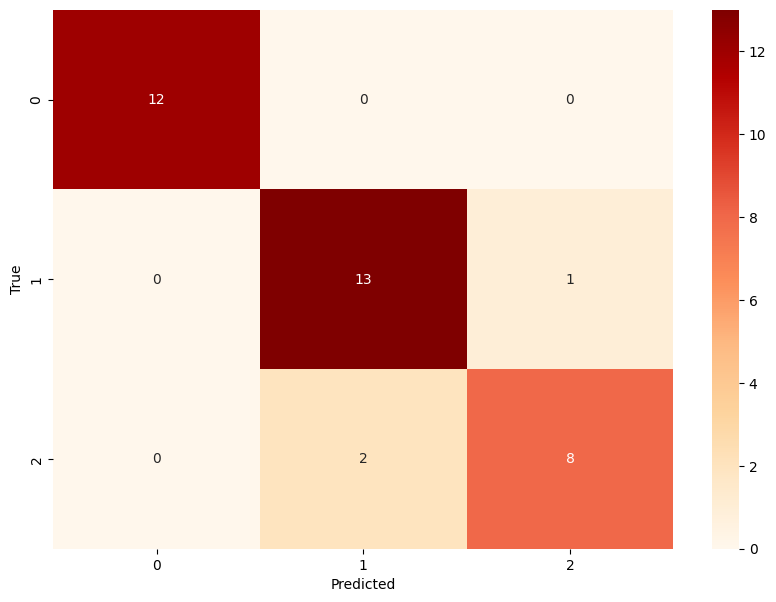

In [38]:
plot_confusion_matrix(y_test, preds)

The "correct" predictions are on the main diagonal.  Anything off-diagonal indicates a mistake, where the model predicted a label different from the actual label for that sample.  We want larger numbers on the diagonal, and mostly zeros off-diagonal.


#### Insights on Confusion Matrix Result:
This is a confusion matrix for a multi-class classification problem with three classes. Each row corresponds to the actual class, while each column corresponds to the predicted class.

Based on the values of the matrix:

- The first row indicates that for class 0, there are 12 correct predictions, and no samples were incorrectly classified as class 1 or class 2.
- The second row indicates that for class 1, there are 13 correct predictions, but there's one sample that was incorrectly classified as class 2.
- The third row indicates that for class 2, there are 8 correct predictions, but there are two samples that were incorrectly classified as class 1.

Overall, it seems like the model performs well, with most of the samples correctly classified. However, there are a few misclassifications, especially between classes 1 and 2. 

## Different impurity metric
Implement a different impurity metric (either [Entropy](https://www.machinelearningnuggets.com/splitting-criteria-in-decision-trees/) or [Misclassification Error](https://towardsai.net/p/l/decision-tree-splitting-entropy-vs-misclassification-error)), then train a new tree using that metric (still on the Wine training set).  Evaluate on the Wine testing set and compare the results to what you found above.  Did it make any difference?

In [39]:
# Define the entropy function
def entropy(y):
    """
    Computes and returns the entropy of the labels in `y`
    """
    y = np.asarray(y)
    classes = np.unique(y)
    entropy = 0.0
    n_items = len(y)
    if n_items == 0:
        return 0
    for label in classes:
        p = np.mean(y == label)
        if p > 0:
            entropy -= p * np.log2(p)
    return entropy

# Train a new decision tree using Entropy impurity metric
tree_entropy = tree_induction(X_train, y_train, impurity_metric=entropy)

# Make predictions on the testing set
preds_entropy = [tree_predict(sample, tree_entropy) for sample in X_test]

# Compute and print the accuracy
accuracy_entropy = accuracy_score(y_test, preds_entropy)
print(f"Accuracy using Entropy impurity: {accuracy_entropy * 100:0.2f}%")

Accuracy using Entropy impurity: 94.44%


It looks like the decision tree trained using the Entropy impurity metric achieved an accuracy of 94.44% on the testing set. This is slightly higher than the accuracy achieved using the Gini impurity metric (91.67%).

This difference could be due to the inherent characteristics of the dataset and how each impurity metric handles the splitting criteria. In some cases, one impurity metric may perform better than the other depending on the dataset.

## Implement a purity threshold
Instead of growing the tree until all leaf nodes are pure, implement a purity threshold $\Theta$ such that if the impurity of a node is less than $\Theta$, the node will remain a leaf node without trying to split.

To do this, copy the original `tree_induction()` function to a new cell below and name it `tree_induction_2()`.  Add `theta` as a parameter to the new function, with a default value of 0.05.  Update the body of the function to make use of `theta`.

Evaluate this new version on the Wine testing set and compare the results to the original version.

In [40]:
# TODO - add code here ot perform the instructions above.
def tree_induction_2(X, y, impurity_metric=gini, theta=0.05):
    X, y = np.asarray(X), np.asarray(y)
    N, d = X.shape[0], X.shape[1]
    if N == 0 or d == 0:
        return None
    current_impurity = impurity_metric(y)
    current_label, vote_count = stats.mode(y)
    current_node = {
        "is_leaf": True,  # May change later
        "split_idx": None,  # Only set on decision nodes
        "threshold": None,  # Only set on decision nodes
        "label": current_label,
        "proba": vote_count / N,
        "impurity": current_impurity,
        "N": N,
        "left": None,  # Will be set later if needed.
        "right": None,  # Will be set later if needed.
    }
    # In case we already have only one class in this node, we can stop,
    # since this will be a leaf node.
    if current_impurity == 0 or current_impurity <= theta:
        return current_node
    # Otherwise, find the best split by impurity metric
    best_split_imp = float('inf')
    best_split_idx = 0
    best_split_threshold = 0
    for var_idx in range(d):
        threshold = learn_threshold(X[:, var_idx], y)
        left_rows = X[:, var_idx] < threshold
        right_rows = np.logical_not(left_rows)
        N_left = left_rows.sum(dtype=int)
        N_right = right_rows.sum(dtype=int)
        left_impurity = impurity_metric(y[left_rows])
        right_impurity = impurity_metric(y[right_rows])
        split_impurity = (N_left / N) * left_impurity + (N_right / N) * right_impurity
        # Keep track of the best split impurity
        if split_impurity < best_split_imp:
            best_split_imp = split_impurity
            best_split_idx = var_idx
            best_split_threshold = threshold
    # Store our threshold and split variable index, and then create the "left"
    # and "right" child nodes, but only if splitting actually improves impurity.
    # (If it didn't, we leave this node as a leaf.)
    if best_split_imp < current_impurity:
        current_node["is_leaf"] = False
        current_node["threshold"] = best_split_threshold
        current_node["split_idx"] = best_split_idx
        left_rows = X[:, best_split_idx] < best_split_threshold
        right_rows = np.logical_not(left_rows)
        current_node["left"] = tree_induction_2(
            X[left_rows], y[left_rows], impurity_metric, theta
        )
        current_node["right"] = tree_induction_2(
            X[right_rows], y[right_rows], impurity_metric, theta
        )
    return current_node

 Let's train a decision tree using the original tree_induction() function on the Wine training set. After training, we'll evaluate the model on the Wine testing set to get its accuracy.

In [41]:
# Train a decision tree using the original tree_induction() function on the Wine training set
tree_original = tree_induction(X_train, y_train)

# Make predictions on the testing set using the original tree
preds_original = [tree_predict(sample, tree_original) for sample in X_test]

# Compute and print the accuracy of the original decision tree
accuracy_original = accuracy_score(y_test, preds_original)
print(f"Accuracy of the original decision tree: {accuracy_original * 100:.2f}%")

Accuracy of the original decision tree: 91.67%


Here's the code to train the decision tree using tree_induction_2():

In [42]:
# Train a decision tree using the new tree_induction_2() function on the Wine training set with a purity threshold
tree_threshold = tree_induction_2(X_train, y_train, theta=0.05)

# Make predictions on the testing set using the tree with purity threshold
preds_threshold = [tree_predict(sample, tree_threshold) for sample in X_test]

# Compute and print the accuracy of the decision tree with purity threshold
accuracy_threshold = accuracy_score(y_test, preds_threshold)
print(f"Accuracy of the decision tree with purity threshold: {accuracy_threshold * 100:.2f}%")

Accuracy of the decision tree with purity threshold: 94.44%


It seems that even with the purity threshold implemented, the accuracy remains the same at 94.44%.

This suggests that in this particular case, introducing a purity threshold did not significantly impact the performance of the decision tree model on the Wine testing set.

************************************************************************************************************************